# Explaining XGBoost model predictions with Shapley values

## Plain English summary

Machine learning models often do not offer an easy way to determine how they have arrived at a prediction, and have been referred to as a "black box". 

Even with our simplified model with 8 features, the model algorithm does not report how it has arrived at a prediction. Shapley values report the average contribution a feature has on the models outcome, across all possible combination of inputs. Shapley values are calculated externally from the model. We will use them to explore what influence each feature has on the models prediction - they can either show information for an individual instance (see which feature pulls the outcome in which direction), or for the global case for the full set of instances.

On an instance level, waterfall plots clearly show the feature contribution to the models prediction. Overall, the shapley values rank the five most influential features as: stroke type, arrival-to-scan time, stroke severity, precise onset time, prior disability level. On a global level beeswarm and scatter plots all help to explain the relationship between feature values and model prediction.

The model does provide a measure of feature importance. We found that there is a reasonable similarity between the feature importance and the SHAP values, but with some differences in the ranked order. Both the SHAP values and feature importance values have good consistency across the 5 k-fold splits.

## Model and data

XGBoost models were trained on stratified k-fold cross-validation data. The 8 features in the model are:

* Arrival-to-scan time: Time from arrival at hospital to scan (mins)
* Infarction: Stroke type (1 = infarction, 0 = haemorrhage)
* Stroke severity: Stroke severity (NIHSS) on arrival
* Precise onset time: Onset time type (1 = precise, 0 = best estimate)
* Prior disability level: Disability level (modified Rankin Scale) before stroke
* Stroke team: Stroke team attended
* Use of AF anticoagulents: Use of atrial fibrillation anticoagulant (1 = Yes, 0 = No)
* Onset-to-arrival time: Time from onset of stroke to arrival at hospital (mins)

And one target feature:
* Thrombolysis: Recieve thrombolysis (1 = Yes, 0 = No)

The 8 features included in the model (to predict whether a patient will recieve thrombolysis) were chosen sequentially as having the single best improvement in model performance (using the ROC AUC). The stroke team feature is included as a one-hot encoded feature.

The Python library SHAP was applied to each of the 5 fitted models (one per kfold) to obtain a SHAP value for each feature, for each instance. SHAP values are in the same units as the model output, so for XGBoost this is in log odds-ratio.

A single SHAP value per feature (to compare with the feature importance value) was obtained by taking the mean of the absolute values across all instances. Then for both cases (feature importance and SHAP) take the median across the 5 kfolds.

## Aims:

* Fit XGBoost model to each of the 5 k-fold train/test splits.
* Get SHAP values for each k-fold split.
* Examine consistency of SHAP values across the 5 k-fold splits.
* Get XGBoost feature importance values for each k-fold split.
* Examine consistency of XGBoost feature importance values across the 5 k-fold splits.
* Compare SHAP values and XGBoost feature importance values.
* Further investigate the relationship between feature values and SHAP values with:
    * Beeswarm plots
    * Waterfall plots
    * Scatter plots
* Show an example of plotting SHSP values in a waterfall plot as probabilities rather than log odds-ratio.

## Observations

* There was good consiency of SHAP values and importances across 5 k-fold replications.
* There was a reasonable correlation between SHAP and feature importance values, but also some differences in the rank order of importance.
    The five most influential features as judged by SHAP were:
    * Stroke type
    * Arrival-to-scan time
    * Stroke severity (NIHSS)
    * Stroke onset time type (precise vs. estimated)
    * Disability level (Rankin) before stroke
* The five most influential features (excluding teams) as judged by importance were:
    * Stroke type
    * Use of AF Anticoagulant
    * Stroke onset time type (precise vs. estimated)
    * Stroke severity (NIHSS)
    * Disability level (Rankin) before stroke
* Beeswarm, waterfall, and scatter plots all help elucidate the relationship between feature values and SHAP value.
* Plotting SHAP values as probabilities are more understandable than plotting as log odds-ratios, but can distort the relative importance of features overall.

### Note on shap version 0.40:

Installed using `pip install shap`

There is a bug in the waterfall plot where `show=False` (required to save plot) fails. To correct this find the `_waterfall.py` file in the shap library (e.g. in `anaconda/envs/samuel2/lib/python3.8/site-packages/shap/plots`, and search/replace all `pl.` to `plt.`, and replace initial import of `import matplotlib.pyplot as pl` with `import matplotlib.pyplot as plt`.

## Load packages

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import shap

from xgboost import XGBClassifier

import json

## Create output folders if needed

In [2]:
path = './saved_models'
if not os.path.exists(path):
    os.makedirs(path)

## Read in JSON file

Contains a dictionary for plain English feature names for the 8 features selected in the model. Use these as the column titles in the DataFrame.

In [3]:
with open("./output/feature_name_dict.json") as json_file:
    feature_name_dict = json.load(json_file)

## Load data

Data has previously been split into 5 stratified k-fold splits.

In [4]:
data_loc = '../data/kfold_5fold/'

In [5]:
# Initialise empty lists
train_data, test_data = [], []

# Read in the names of the selected features for the model
number_of_features_to_use = 8
key_features = pd.read_csv('./output/feature_selection.csv')
key_features = list(key_features['feature'])[:number_of_features_to_use]
# And add the target feature name: S2Thrombolysis
key_features.append('S2Thrombolysis')

# For each k-fold split
for i in range(5):
    # Read in training set, restrict to chosen features, rename titles, & store
    train = pd.read_csv(data_loc + 'train_{0}.csv'.format(i))
    train = train[key_features]
    train.rename(columns=feature_name_dict, inplace=True)
    train_data.append(train)
    # Read in test set, restrict to chosen features, rename titles, & store
    test = pd.read_csv(data_loc + 'test_{0}.csv'.format(i))
    test = test[key_features]
    test.rename(columns=feature_name_dict, inplace=True)
    test_data.append(test)

## Fit XGBoost model

Fit XGBoost model for each k-fold training/test split, and get feature importance values (a value per feature, per model from each k-fold split)

In [6]:
# Fit models (True), or load models (False)
fit_models = True

# Set up lists for k-fold fits
model_kfold = []
importances_kfold = []
y_pred_kfold = []
y_prob_kfold = []
X_train_kfold = []
X_test_kfold = []
y_train_kfold = []
y_test_kfold = []

# For each k-fold split
for k in range(5):
    # Get X and y
    X_train = train_data[k].drop('Thrombolysis', axis=1)
    X_test = test_data[k].drop('Thrombolysis', axis=1)
    y_train = train_data[k]['Thrombolysis']
    y_test = test_data[k]['Thrombolysis']

    # One hot encode hospitals
    X_train_hosp = pd.get_dummies(X_train['Stroke team'], prefix = 'team')
    X_train = pd.concat([X_train, X_train_hosp], axis=1)
    X_train.drop('Stroke team', axis=1, inplace=True)
    X_test_hosp = pd.get_dummies(X_test['Stroke team'], prefix = 'team')
    X_test = pd.concat([X_test, X_test_hosp], axis=1)
    X_test.drop('Stroke team', axis=1, inplace=True)
    
    # Store processed X and y
    X_train_kfold.append(X_train)
    X_test_kfold.append(X_test)
    y_train_kfold.append(y_train)
    y_test_kfold.append(y_test)
    
    if fit_models:
        # Define and Fit model
        model = XGBClassifier(verbosity = 0, seed=42, learning_rate=0.5)
        model.fit(X_train, y_train)
        model_kfold.append(model)

        # Save using pickle
        filename = f'./saved_models/combined_xgb_model_key_features_{k}.p'
        with open(filename, 'wb') as filehandler:
            pickle.dump(model, filehandler)
    
    else:
        # Load models
        filename = f'./saved_models/combined_xgb_model_key_features_{k}.p'
        with open(filename, 'rb') as filehandler:
            model = pickle.load(filehandler)
            model_kfold.append(model)        

    # Get and store feature importance values
    features = list(X_train)
    feature_importances = model.feature_importances_
    importances = pd.DataFrame(index=features)
    importances['importance'] = feature_importances
    importances['rank'] = importances['importance'].rank(ascending=False).values
    importances_kfold.append(importances)

    # Get and store predicted class and probability
    y_pred = model.predict(X_test)
    y_pred_kfold.append(y_pred)
    y_prob = model.predict_proba(X_test)[:, 1]
    y_prob_kfold.append(y_prob)

    # Measure accuracy for this k-fold model
    accuracy = np.mean(y_pred == y_test)
    print(f'Accuracy k-fold {k+1}: {accuracy:0.3f}')

Accuracy k-fold 1: 0.846
Accuracy k-fold 2: 0.853
Accuracy k-fold 3: 0.845
Accuracy k-fold 4: 0.849
Accuracy k-fold 5: 0.844


## Shap values

We will use the SHAP library: https://shap.readthedocs.io/en/latest/index.html

'Raw' SHAP values from XGBoost model are log odds ratios.
A SHAP value is returned for each feature, for each instance, for each model (one per k-fold)

### Get Shap values

In [7]:
calculate_shap_values = True # Otherwise load Shap values

# Initialise empty lists
k_fold_shap_values_extended = []
k_fold_shap_values = []

# For each k-fold split
for k in range(5):
    if calculate_shap_values:
        # Calculate SHAP values
        
        # Set up explainer using the model and feature values from training set
        explainer = shap.TreeExplainer(model_kfold[k], X_train_kfold[k])

        # Get (and store) Shapley values along with base and feature values
        shap_values_extended = explainer(X_test_kfold[k])
        k_fold_shap_values_extended.append(shap_values_extended)
        # Shap values exist for each classification in a Tree
        # We are interested in 1=give thrombolysis (not 0=not give thrombolysis)
        shap_values = shap_values_extended.values
        k_fold_shap_values.append(shap_values)        

        # Save using pickle
        filename = f'./output/shap_values_extended_xgb_key_features_{k}.p'
        with open(filename, 'wb') as filehandler:
            pickle.dump(shap_values_extended, filehandler)
        
        # Print progress
        print (f'Completed {k+1} of 5')
        
    else:
        # Load explainer
        filename = f'./output/shap_values_extended_xgb_key_features_{k}.p'
        with open(filename, 'rb') as filehandler:
            shap_values_extended = pickle.load(filehandler)
            k_fold_shap_values_extended.append(shap_values_extended)
            k_fold_shap_values.append(shap_values_extended.values)

 98%|===================| 17419/17759 [00:21<00:00]        

Completed 1 of 5


 99%|===================| 17656/17759 [00:23<00:00]        

Completed 2 of 5


 99%|===================| 17497/17758 [00:23<00:00]        

Completed 3 of 5


 99%|===================| 17593/17758 [00:26<00:00]        

Completed 4 of 5


 98%|===================| 17339/17758 [00:24<00:00]        

Completed 5 of 5


### Get average SHAP values for each k-fold

For each k-fold split, calculate the mean SHAP value for each feature (across all instances).
The mean is calculated in three ways:
* mean of raw values
* mean of absolute values
* absolute of mean of raw values

In [8]:
# Initialise empty lists
shap_values_mean_kfold = []

# For each k-fold split
for k in range(5):
    # Calculate mean SHAP value for each feature (across all instances)
    shap_values = k_fold_shap_values[k]
    shap_values_mean = pd.DataFrame(index=features)
    shap_values_mean['mean_shap'] = np.mean(shap_values, axis=0)
    shap_values_mean['abs_mean_shap'] = np.abs(shap_values_mean)
    shap_values_mean['mean_abs_shap'] = np.mean(np.abs(shap_values), axis=0)
    shap_values_mean['rank'] = shap_values_mean['mean_abs_shap'].rank(
        ascending=False).values
    shap_values_mean.sort_index()
    shap_values_mean_kfold.append(shap_values_mean)

### Examine consistency of SHAP values across k-fold splits

A model is fitted to each k-fold split, and SHAP values are obtained for each model. This next section assesses the range of SHAP values (mean |Shap|) for each feature across the k-fold splits.

In [9]:
# Initialise DataFrame (stores mean of the absolute SHAP values for each kfold)
mean_abs_shap = pd.DataFrame()

# For each k-fold split
for k in range(5):
    # mean of the absolute SHAP values for each k-fold split
    mean_abs_shap[f'{k}'] = shap_values_mean_kfold[k]['mean_abs_shap']

In [10]:
mean_abs_shap

,0,1,2,3,4
Arrival-to-scan time,1.244143,1.161219,1.050302,1.045449,1.015622
Infarction,2.259876,2.219784,2.136264,2.167213,2.145942
Stroke severity,0.971404,0.897691,0.997946,0.952578,0.984440
Precise onset time,0.644974,0.599893,0.577417,0.612413,0.608663
Prior disability level,0.464659,0.469118,0.485589,0.471484,0.438499
...,...,...,...,...,...
team_YPKYH1768F,0.001261,0.002096,0.001029,0.000489,0.000941
team_YQMZV4284N,0.001066,0.001439,0.001043,0.000956,0.000903
team_ZBVSO0975W,0.002313,0.005012,0.006502,0.001933,0.008406
team_ZHCLE1578P,0.007511,0.002956,0.006738,0.003115,0.005115


Create (and show) a dataframe that stores the min, median, and max SHAP values for each feature across the 5 k-fold splits

In [11]:
mean_abs_shap_summary = pd.DataFrame()
mean_abs_shap_summary['min'] = mean_abs_shap.min(axis=1)
mean_abs_shap_summary['median'] = mean_abs_shap.median(axis=1) 
mean_abs_shap_summary['max'] = mean_abs_shap.max(axis=1)
mean_abs_shap_summary.sort_values('median', inplace=True, ascending=False)

In [12]:
mean_abs_shap_summary

,min,median,max
Infarction,2.136264,2.167213,2.259876
Arrival-to-scan time,1.015622,1.050302,1.244143
Stroke severity,0.897691,0.971404,0.997946
Precise onset time,0.577417,0.608663,0.644974
Prior disability level,0.438499,0.469118,0.485589
...,...,...,...
team_WSFVN0229E,0.000000,0.000439,0.001835
team_APXEE8191H,0.000336,0.000425,0.008395
team_WSNTP4114A,0.000213,0.000422,0.000613
team_QTELJ8888W,0.000000,0.000000,0.002636


Identify the 10 features with the highest SHAP values (in terms of the mean of the absolute SHAP values)

In [13]:
top_10_shap = list(mean_abs_shap_summary.head(10).index)

Create a violin plot for these 10 features with the highest SHAP values.

A violin plot shows the distribution of the SHAP values for each feature across the 5 kfold splits. The bars show the min, median and max values for the feature, and the shaded area around the bars show the density of the data points.

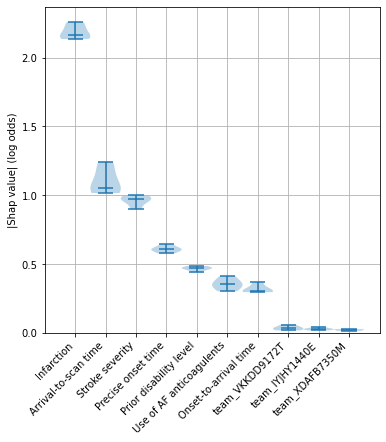

In [14]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax1.violinplot(mean_abs_shap.loc[top_10_shap].T,
               showmedians=True,
               widths=1)
ax1.set_ylim(0)
labels = top_10_shap
ax1.set_xticks(np.arange(1, len(labels) + 1))
ax1.set_xticklabels(labels, rotation=45, ha='right')
ax1.grid(which='both')
ax1.set_ylabel('|Shap value| (log odds)')
plt.savefig('output/shap_violin_key_features.jpg', dpi=300, 
            bbox_inches='tight', pad_inches=0.2)
plt.show()

### Examine the consitency of feature importances across k-fold splits

XGBoost algorithm provides a metrc per feature called "feature importance".

A model is fitted to each k-fold split, and feature importance values are obtained for each model. This next section assesses the range of feature importance values for each feature across the k-fold splits.

In [15]:
# Initialise DataFrame (stores feature importance values for each kfold)
importances_df = pd.DataFrame()

# For each k-fold
for k in range(5):
    # feature importance value for each k-fold split
    importances_df[f'{k}'] = importances_kfold[k]['importance']

Create (and show) a dataframe that stores the min, median, and max feature importance value for each feature across the 5 k-fold splits

In [16]:
importances_summary = pd.DataFrame()
importances_summary['min'] = importances_df.min(axis=1)
importances_summary['median'] = importances_df.median(axis=1) 
importances_summary['max'] = importances_df.max(axis=1)
importances_summary.sort_values('median', inplace=True, ascending=False)

In [17]:
importances_summary

,min,median,max
Infarction,0.342151,0.347804,0.368849
Use of AF anticoagulents,0.039643,0.047754,0.056500
Precise onset time,0.025313,0.027453,0.031848
team_MHMYL4920B,0.011515,0.012891,0.013842
Stroke severity,0.011592,0.012466,0.013186
...,...,...,...
team_VVDIY0129H,0.000413,0.001124,0.002185
team_FWHZZ0143J,0.000470,0.000582,0.002095
team_WSFVN0229E,0.000000,0.000362,0.002803
team_QTELJ8888W,0.000000,0.000000,0.001831


Identify the 10 features with the highest feature importance values.

In [18]:
top_10_importances = list(importances_summary.head(10).index)

Create a violin plot for these 10 features with the highest feature importance values.

A violin plot shows the distribution of the feature importance values for each feature across the 5 kfold splits. The bars show the min, median and max values for the feature, and the shaded area around the bars show the density of the data points.

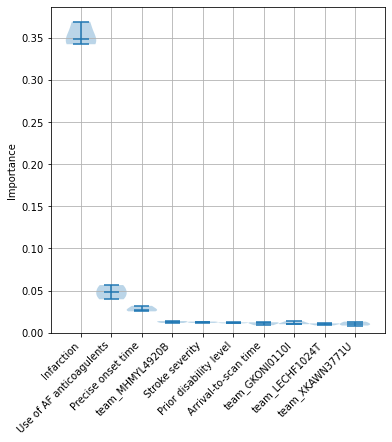

In [19]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax1.violinplot(importances_summary.loc[top_10_importances].T,
              showmedians=True,
              widths=1)
ax1.set_ylim(0)
labels = top_10_importances
ax1.set_xticks(np.arange(1, len(labels) + 1))
ax1.set_xticklabels(labels, rotation=45, ha='right')
ax1.grid(which='both')
ax1.set_ylabel('Importance')
plt.savefig('output/importance_violin_key_features.jpg', dpi=300, 
            bbox_inches='tight', pad_inches=0.2)
plt.show()

### Compare top 10 SHAP and feature importance values

Compare the features (and their values) that make the top 10 when selected by either SHAP values, or feature importance values

In [20]:
compare_shap_importance = pd.DataFrame()
compare_shap_importance['SHAP (feature name)'] = \
                            mean_abs_shap_summary.index
compare_shap_importance['SHAP (median value)']  = \
                            mean_abs_shap_summary['median'].values
compare_shap_importance['Importance (feature name)'] = \
                                importances_summary.index
compare_shap_importance['Importance (median value)'] = \
                            importances_summary['median'].values
compare_shap_importance.head(10)

,SHAP (feature name),SHAP (median value),Importance (feature name),Importance (median value)
0,Infarction,2.167213,Infarction,0.347804
1,Arrival-to-scan time,1.050302,Use of AF anticoagulents,0.047754
2,Stroke severity,0.971404,Precise onset time,0.027453
3,Precise onset time,0.608663,team_MHMYL4920B,0.012891
4,Prior disability level,0.469118,Stroke severity,0.012466
5,Use of AF anticoagulents,0.351979,Prior disability level,0.011766
6,Onset-to-arrival time,0.305040,Arrival-to-scan time,0.011375
7,team_VKKDD9172T,0.034521,team_GKONI0110I,0.010816
8,team_IYJHY1440E,0.027590,team_LECHF1024T,0.010366
9,team_XDAFB7350M,0.021129,team_XKAWN3771U,0.010366


Plot all of the features, showing feature importance vs SHAP values.

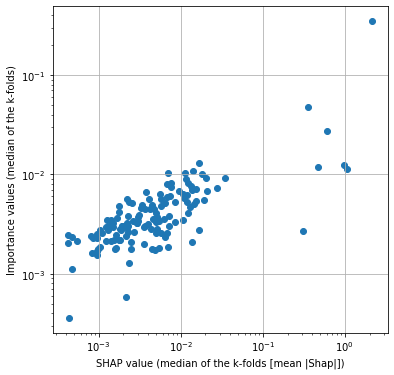

In [21]:
shap_importance = pd.DataFrame()
shap_importance['Shap'] = mean_abs_shap_summary['median']
shap_importance = shap_importance.merge(
    importances_summary['median'], left_index=True, right_index=True)
shap_importance.rename(columns={'median':'Importance'}, inplace=True)
shap_importance.sort_values('Shap', inplace=True, ascending=False)

fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax1.scatter(shap_importance['Shap'],
            shap_importance['Importance'])
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('SHAP value (median of the k-folds [mean |Shap|])')
ax1.set_ylabel('Importance values (median of the k-folds)')
ax1.grid()
plt.savefig('output/shap_importance_correlation_key_features.jpg', dpi=300)
plt.show()

## SHAP values in more detail, using the first k-fold

Having established that Shap values have good consistency across k-fold splits, here we show more detail on SHAP using the first k-fold split.

First, get the key values from the first k fold split

In [22]:
model = model_kfold[0]
shap_values = k_fold_shap_values[0]
shap_values_extended = k_fold_shap_values_extended[0]
importances = importances_kfold[0]
y_pred = y_pred_kfold[0]
y_prob = y_prob_kfold[0]
X_train = X_train_kfold[0]
X_test = X_test_kfold[0]
y_train = y_train_kfold[0]
y_test = y_test_kfold[0]

### View the global case: Beeswarm plot

A Beeswarm plot shows data for all instances. 

The feature value for each point is shown by the colour, and its position indicates the SHAP value for that instance.

Beeswarm plots are used to get a global picture of how the feature value interacts with it's SHAP value.

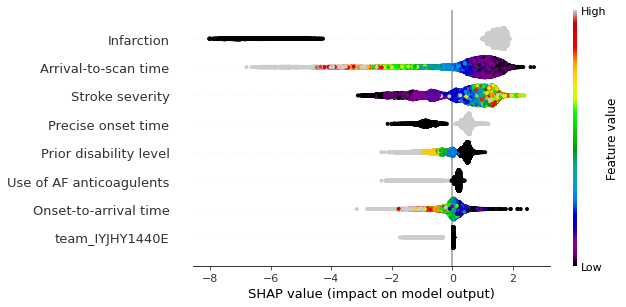

In [23]:
fig = plt.figure(figsize=(6,6))

shap.summary_plot(shap_values=shap_values, 
                  features=X_test,
                  feature_names=features,
                  max_display=8,
                  cmap=plt.get_cmap('nipy_spectral'), show=False)
plt.savefig('output/xgb_beeswarm_key_features.jpg', dpi=300, bbox_inches='tight', 
            pad_inches=0.2)
plt.show()

### View the individual case: Waterfall plots 
(showing log odds ratio)

Waterfall plots are ways of plotting the influence of features for individual cases. Here we show them for two instances: one with low, and one with high probability of receiving thrombolysis.

Note: A decision plot is an alternative method of showing the same data. For further information see here: 
https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/decision_plot.html

In [24]:
# Get the location of an example each where probability of giving thrombolysis
# is <0.1 or >0.9
location_low_probability = np.where(y_prob <0.1)[0][0]
location_high_probability = np.where(y_prob > 0.9)[0][0]

A waterfall plot example with low probability of receiving thrombolysis (showing log odds ratio).

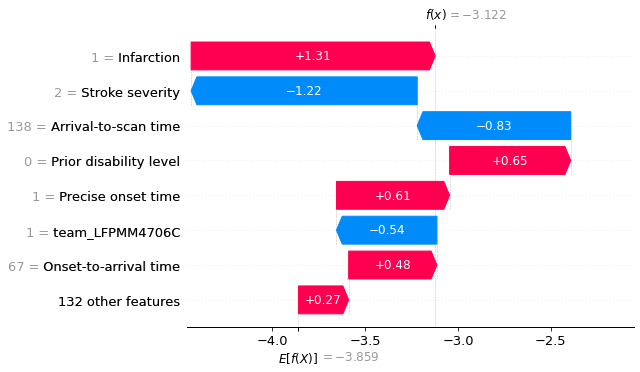

In [25]:
fig = shap.plots.waterfall(shap_values_extended[location_low_probability],
                           show=False, max_display=8)
plt.savefig('output/xgb_waterfall_low_key_features.jpg', dpi=300, bbox_inches='tight',
            pad_inches=0.2)
plt.show()

An waterfall plot example with high probability of receiving thrombolysis (showing log odds ratio).

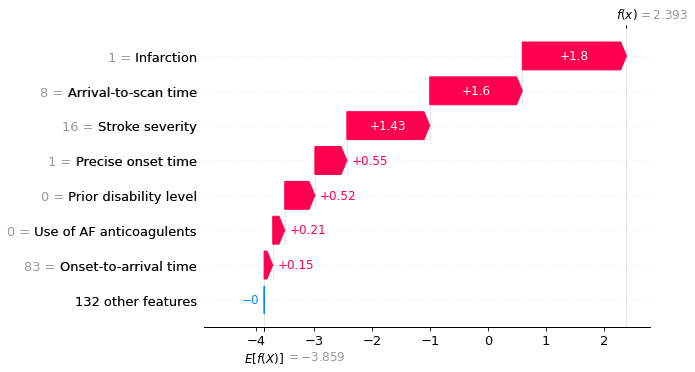

In [26]:
fig = shap.plots.waterfall(shap_values_extended[location_high_probability],
                           show=False, max_display=8)
plt.savefig('output/xgb_waterfall_high_key_features.jpg', dpi=300, bbox_inches='tight',
            pad_inches=0.2)
plt.show()

### View the individual case: Waterfall plots 
(showing probabilities)

Though Shap values for XGBoost most accurately describe the effect on log odds ratio of classification, it may be easier for people to understand influence of features using probabilities. Here we plot the same waterfall plots using probabilities.

A disadvantage of this method is that it distorts the influence of features somewhat - those features pushing the probability down from a low level to an even lower level get 'squashed' in apparent importance. This distortion is avoided when plotting log odds ratio, but at the cost of using an output that is poorly understandable by many.

Here we show the same two instances, with probability rather than log odds ratio.

In [27]:
# Set up explainer using typical feature values from training set
explainer_probability = shap.TreeExplainer(model, X_train, 
                                           model_output='probability')

# Get Shapley values along with base and features
shap_values_probability_extended = explainer_probability(X_test)
shap_values_probability = shap_values_probability_extended.values

 97%|=================== | 17197/17759 [00:30<00:00]       

A waterfall plot example with low probability of receiving thrombolysis (showing probabilites).

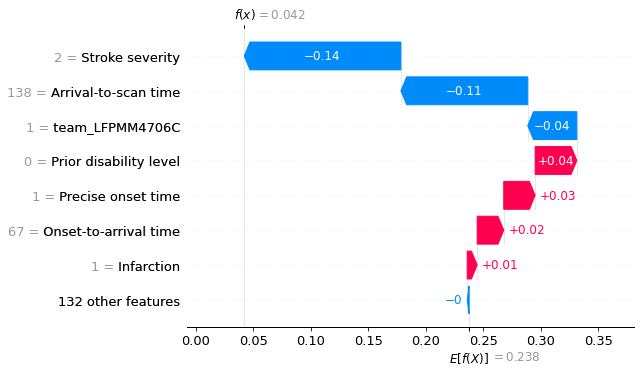

In [28]:
fig = shap.plots.waterfall(
                shap_values_probability_extended[location_low_probability],
                show=False, max_display=8)
plt.savefig('output/xgb_waterfall_low_probability_key_features.jpg', dpi=300, 
            bbox_inches='tight', pad_inches=0.2)
plt.show()

An waterfall plot example with high probability of receiving thrombolysis (showing probabilities).

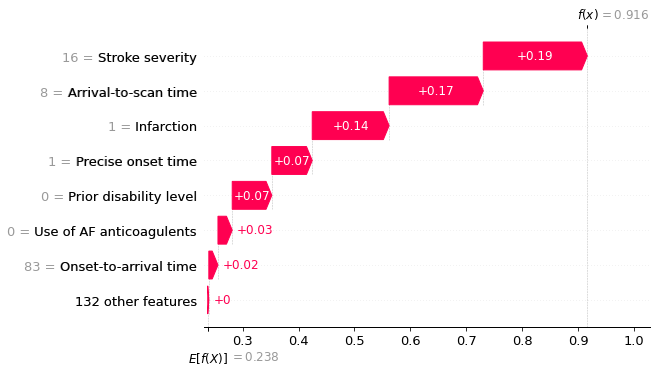

In [29]:
fig = shap.plots.waterfall(
                shap_values_probability_extended[location_high_probability],
                show=False, max_display=8)
plt.savefig('output/xgb_waterfall_high_probability_key_features.jpg', dpi=300, 
            bbox_inches='tight', pad_inches=0.2)
plt.show()

### Show the relationship between feature value and SHAP value for the top 6 influential features
(as shap plots scatter)

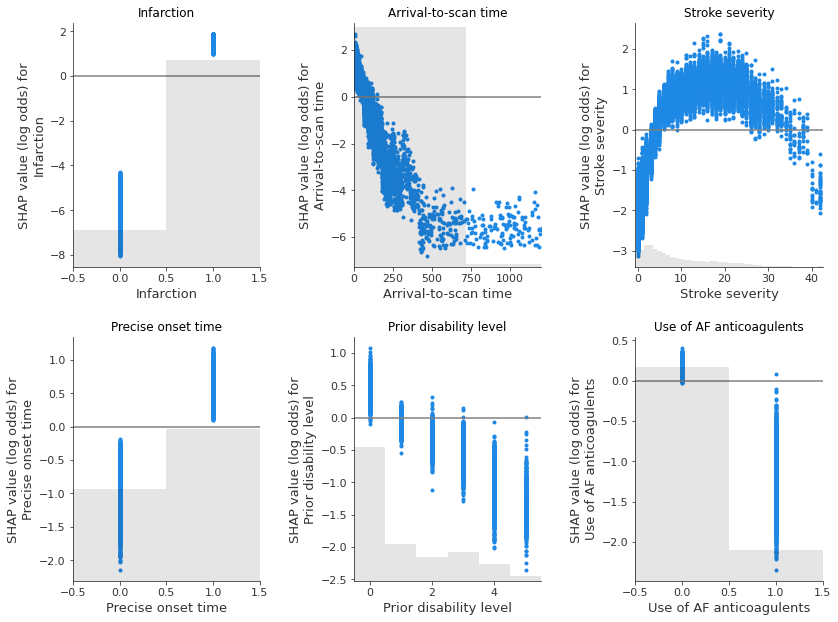

In [30]:
feat_to_show = top_10_shap[0:6]

fig = plt.figure(figsize=(12,9))
for n, feat in enumerate(feat_to_show):    
    ax = fig.add_subplot(2,3,n+1)
    shap.plots.scatter(shap_values_extended[:, feat], x_jitter=0, ax=ax, 
                       show=False)
    
    # Add line at Shap = 0
    feature_values = shap_values_extended[:, feat].data
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0,0], c='0.5')    
    
    ax.set_ylabel(f'SHAP value (log odds) for\n{feat}')
    ax.set_title(feat)
    
    # Censor arrival to scan to 1200 minutes
    if feat == 'Arrival-to-scan time':
        ax.set_xlim(0,1200)
    
plt.tight_layout(pad=2)

fig.savefig('output/xgb_thrombolysis_shap_scatter.jpg', dpi=300,
    bbox_inches='tight', pad_inches=0.2)

### Show the relationship between feature value and SHAP value for the top 5 influential features
(as violin plots)

Resource: 
https://towardsdatascience.com/binning-records-on-a-continuous-variable-with-pandas-cut-and-qcut-5d7c8e11d7b0
https://matplotlib.org/3.1.0/gallery/statistics/customized_violin.html

In [31]:
def set_ax(ax, category_list, feat, rotation=0):
    '''
    ax [matplotlib axis object] = matplotlib axis object
    category_list [list] = used for the xtick labels (the grouping of the data)
    rotation [integer] = xtick label rotation
    feat [string] = used in the axis label, the feature that is being plotted
    
    resource: 
    https://matplotlib.org/3.1.0/gallery/statistics/customized_violin.html
    '''
    # Set the axes ranges and axes labels
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(category_list) + 1))
    ax.set_xticklabels(category_list, rotation=rotation, fontsize=8)
    ax.set_xlim(0.25, len(category_list) + 0.75)
    ax.set_ylabel(f'Shap values for {feat}')
    ax.set_xlabel(f'Feature values for {feat}')
    return(ax)

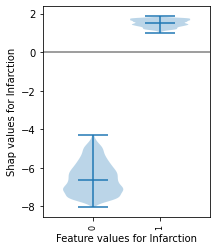

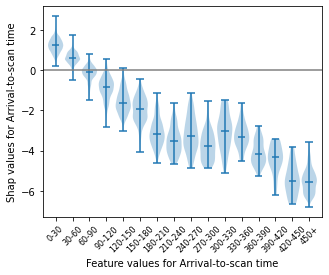

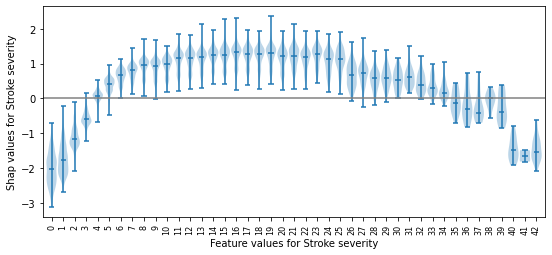

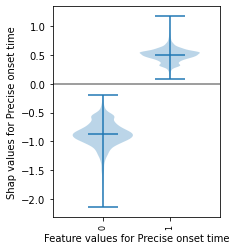

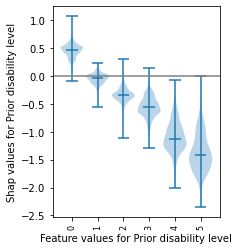

In [32]:
feat_to_show = top_10_shap[0:5]

# for each feature, prepare the data for the violin plot.
# data either already in categories, or if there's more than 50 unique values
# for a feature then assume it needs to be binned, and a violin for each bin
for feat in feat_to_show:
    feature_data = shap_values_extended[:, feat].data
    feature_shap = shap_values_extended[:, feat].values

    # if feature has more that 50 unique values, then assume it needs to be 
    # binned (other assume they are unique categories)
    if np.unique(feature_data).shape[0] > 50:
        # bin the data, create a violin per bin
        
        # settings for the plot
        rotation = 45
        step = 30
        n_bins = min(16, np.int((feature_data.max())/step))
        
        # create list of bin values
        bin_list = [(i*step) for i in range(n_bins)]
        bin_list.append(feature_data.max())

        # create list of bins (the unique categories)
        category_list =  [f'{i*step}-{(i+1)*step}' for i in range(n_bins-1)]
        category_list.append(f'{(n_bins-1)*step}+')

        # bin the feature data
        feature_data = pd.cut(feature_data, bin_list, labels=category_list)

    else:
        # create a violin per unique value
        
        # settings for the plot
        rotation = 90
        
        # create list of unique categories in the feature data
        category_list = np.unique(feature_data)
        category_list = [int(i) for i in category_list]

    # create a list, each entry contains the corresponsing Shap value for that 
    # category (or bin). A violin will represent each list.    
    shap_per_category = []
    for category in category_list:
        mask = feature_data == category
        shap_per_category.append(feature_shap[mask])

    # figure width as a function of the number of categories
    width = np.int(len(category_list)/7)

    # create violin plot
    fig, ax = plt.subplots(figsize=(width+3, 4))
    ax.violinplot(shap_per_category, showmedians=True, widths=0.9) 
    
    # customise the axes
    ax = set_ax(ax, category_list, feat, rotation=rotation)
    plt.subplots_adjust(bottom=0.15, wspace=0.05)
    
    # Add line at Shap = 0
    feature_values = shap_values_extended[:, feat].data
    ax.plot([0, len(feature_values)], [0,0],c='0.5')   
    
    fig.savefig(
        f'output/xgb_thrombolysis_shap_violin_{feat}.jpg', dpi=300,
         bbox_inches='tight', pad_inches=0.2)

## Observations

* There was good consiency of Shap values and importances across 5 k-fold replications.
* There was a reasonable correlation between Shap and imortance values, but also some differences in the rank order of importance.
    The five most influential features as judged by Shap were:
    * Stroke type
    * Arrival-to-scan time
    * Stroke severity (NIHSS)
    * Stroke onset time type (precise vs. estimated)
    * Disability level (Rankin) before stroke
* The five most influential features (excluding teams) as judged by importance were:
    * Stroke type
    * Use of AF Anticoagulant
    * Stroke onset time type (precise vs. estimated)
    * Stroke severity (NIHSS)
    * Disability level (Rankin) before stroke
* Beeswarm, waterfall, and scatter plots all help elucidate the relationship between feature values and Shap value.
* Plotting Shap values as probabilities are more understandable than plotting as log odds-ratios, but can distort the relative importance of features overall.